In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import pandas as pd
import numpy as np
import os

#  Base path
base_path = "/kaggle/input/fgvc-aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data"

# Load mapping files
def load_mapping(file_path, label_type):
    mapping = []
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split(" ", 1)
            if len(parts) == 2:
                mapping.append((parts[0], parts[1]))
    return pd.DataFrame(mapping, columns=["image", label_type])

variant_df = load_mapping(f"{base_path}/images_variant_trainval.txt", "variant")
family_df = load_mapping(f"{base_path}/images_family_trainval.txt", "family")
maker_df = load_mapping(f"{base_path}/images_manufacturer_trainval.txt", "maker")

#  Merge labels on 'image'
df = variant_df.merge(family_df, on="image").merge(maker_df, on="image")

#  Group by variant to get canonical family & maker
hierarchy = df.groupby("variant")[["family", "maker"]].agg(lambda x: x.mode().iloc[0]).reset_index()

#  Create ID maps
variant_to_id = {v: i for i, v in enumerate(hierarchy["variant"].sort_values().unique())}
family_to_id = {f: i for i, f in enumerate(hierarchy["family"].sort_values().unique())}
maker_to_id = {m: i for i, m in enumerate(hierarchy["maker"].sort_values().unique())}

#  Map IDs
hierarchy["variant_id"] = hierarchy["variant"].map(variant_to_id)
hierarchy["family_id"] = hierarchy["family"].map(family_to_id)
hierarchy["maker_id"] = hierarchy["maker"].map(maker_to_id)

#  Optional: Create lookup dicts for later use
variant_to_family = hierarchy.set_index("variant_id")["family_id"].to_dict()
variant_to_maker = hierarchy.set_index("variant_id")["maker_id"].to_dict()

#  Save CSV
output_path = "/kaggle/working/hierarchy_full.csv"
hierarchy.to_csv(output_path, index=False)

#  Confirm
print(" hierarchy_full.csv saved with columns:", hierarchy.columns.tolist())
print(f" Classes: {len(variant_to_id)} variants, {len(family_to_id)} families, {len(maker_to_id)} makers")


In [ ]:
#  Step 1: Prepare variant to family/maker hierarchy and task splits
import pandas as pd
import os
import random
import json

# Path to original FGVC Aircraft data
base_path = "/kaggle/input/fgvc-aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data"

# Load mapping from original trainval files
def load_mapping(file_path, label_type):
    mapping = []
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split(" ", 1)
            if len(parts) == 2:
                mapping.append((parts[0], parts[1]))
    return pd.DataFrame(mapping, columns=["image", label_type])

variant_df = load_mapping(f"{base_path}/images_variant_trainval.txt", "variant")
family_df = load_mapping(f"{base_path}/images_family_trainval.txt", "family")
maker_df = load_mapping(f"{base_path}/images_manufacturer_trainval.txt", "maker")

# Merge into a full image-level dataframe
df = variant_df.merge(family_df, on="image").merge(maker_df, on="image")

# Get the variant-level hierarchy (unique mapping assumed)
hierarchy = df.groupby("variant")[["family", "maker"]].agg(lambda x: x.mode()[0]).reset_index()

# Save the full hierarchy
hierarchy_path = "/kaggle/working/hierarchy_full.csv"
hierarchy.to_csv(hierarchy_path, index=False)

#  Step 2: Split variants into 10 tasks randomly
variants = hierarchy["variant"].tolist()
random.seed(42)
random.shuffle(variants)

num_tasks = 20
variants_per_task = len(variants) // num_tasks

# Build task split dictionary with full hierarchy per variant
task_hierarchy = {}
for i in range(num_tasks):
    task_name = f"task_{i+1}"
    task_variants = variants[i*variants_per_task:(i+1)*variants_per_task]
    task_data = []
    for var in task_variants:
        fam = hierarchy[hierarchy["variant"] == var].iloc[0]["family"]
        mak = hierarchy[hierarchy["variant"] == var].iloc[0]["maker"]
        task_data.append({"variant": var, "family": fam, "manufacturer": mak})
    task_hierarchy[task_name] = task_data

# Save task split to JSON
with open("/kaggle/working/task_split.json", "w") as f:
    json.dump(task_hierarchy, f, indent=4)

print(" Task split with hierarchy saved to task_split.json")


In [4]:
import json

# Load task split JSON
with open("/kaggle/working/task_split.json", "r") as f:
    task_data = json.load(f)

# Display all tasks
for task_name, variants in task_data.items():
    print(f"\n🔹 {task_name} ({len(variants)} variants):")
    for entry in variants:
        print(f"  - Variant: {entry['variant']}, Family: {entry['family']}, Maker: {entry['manufacturer']}")



🔹 task_1 (5 variants):
  - Variant: C-130, Family: C-130, Maker: Lockheed Corporation
  - Variant: Boeing 717, Family: Boeing 717, Maker: Boeing
  - Variant: PA-28, Family: PA-28, Maker: Piper
  - Variant: 737-900, Family: Boeing 737, Maker: Boeing
  - Variant: E-190, Family: Embraer E-Jet, Maker: Embraer

🔹 task_2 (5 variants):
  - Variant: Cessna 560, Family: Cessna Citation, Maker: Cessna
  - Variant: 727-200, Family: Boeing 727, Maker: Boeing
  - Variant: Embraer Legacy 600, Family: Embraer Legacy 600, Maker: Embraer
  - Variant: 757-300, Family: Boeing 757, Maker: Boeing
  - Variant: Fokker 70, Family: Fokker 70, Maker: Fokker

🔹 task_3 (5 variants):
  - Variant: F/A-18, Family: F/A-18, Maker: McDonnell Douglas
  - Variant: 747-100, Family: Boeing 747, Maker: Boeing
  - Variant: DC-8, Family: DC-8, Maker: Douglas Aircraft Company
  - Variant: DC-9-30, Family: DC-9, Maker: McDonnell Douglas
  - Variant: F-16A/B, Family: F-16, Maker: Lockheed Martin

🔹 task_4 (5 variants):
  - Vari

In [ ]:
import os
import json
import torch
from PIL import Image
import numpy as np
from skimage.segmentation import slic
from skimage.util import img_as_float
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from tqdm import tqdm

#  Paths
base_path = "/kaggle/input/fgvc-aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data"
img_dir = os.path.join(base_path, "images")
seg_dir = "/kaggle/working/segment_maps"
mapping_file = "/kaggle/working/mapping.txt"
task_split_path = "/kaggle/working/task_split.json"
variant_label_file = os.path.join(base_path, "images_variant_trainval.txt")

#  Create output directory
os.makedirs(seg_dir, exist_ok=True)
mapping = []

#  Step 1: Load task split
with open(task_split_path, "r") as f:
    task_split = json.load(f)

#  Step 2: Get list of allowed variants from all tasks
all_variants = set()
for task_data in task_split.values():
    for entry in task_data:
        all_variants.add(entry["variant"])

#  Step 3: Safe parser for image → variant mapping
def load_variant_mapping(file_path):
    records = []
    with open(file_path, "r") as f:
        for line in f:
            parts = line.strip().split(" ", 1)
            if len(parts) == 2:
                image, variant = parts
                records.append((image, variant))
    return pd.DataFrame(records, columns=["image", "variant"])

variant_df = load_variant_mapping(variant_label_file)
variant_df = variant_df[variant_df["variant"].isin(all_variants)].drop_duplicates().sort_values("image")

#  Step 4: Generate segment maps only for selected images
print(f" Generating superpixel maps for {len(variant_df)} images in task variant split...")

skipped = 0

for _, row in tqdm(variant_df.iterrows(), total=len(variant_df)):
    image_id = row["image"]
    img_path = os.path.join(img_dir, f"{image_id}.jpg")
    
    if not os.path.exists(img_path):
        skipped += 1
        continue

    try:
        image = Image.open(img_path).convert("RGB")
        resized = image.resize((224, 224))
        image_np = img_as_float(np.array(resized))

        segments = slic(image_np, n_segments=196, compactness=10, start_label=0)
        flat = segments.flatten()
        encoder = LabelEncoder()
        encoded = encoder.fit_transform(flat)
        normalized_segments = encoded.reshape(224, 224)

        seg_tensor = torch.from_numpy(normalized_segments).long()
        seg_save_path = os.path.join(seg_dir, image_id + ".pt")
        torch.save(seg_tensor, seg_save_path)

        mapping.append(f"{image_id} segment_maps/{image_id}.pt")
    except Exception as e:
        print(f"⚠️ Skipping {image_id}: {e}")
        skipped += 1

#  Save mapping file
with open(mapping_file, "w") as f:
    f.writelines([line + "\n" for line in mapping])

#  Summary
print(f"\n Completed generation of superpixel maps.")
print(f" mapping.txt saved at {mapping_file}")
print(f"  Total segment maps created: {len(mapping)}")
print(f" Skipped or failed images: {skipped}")


In [6]:
!mkdir -p cast_models


In [ ]:
%%writefile cast_models/aircraft_dataset.py
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as T

class AircraftHCASTDataset(Dataset):
    """
    Aircraft HCAST Dataset for Hierarchical Classification.
    Includes an optional flag to include segment maps or not.
    """
    def __init__(self, image_dir, label_file, image_split_file, mapping_file,
                 transform=None, use_segments=True, debug=False):
        self.image_dir = image_dir
        self.debug = debug
        self.use_segments = use_segments

        #  Default image transform
        self.transform = transform or T.Compose([
            T.Resize((224, 224)),
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
        ])

        #  Load hierarchy
        self.hierarchy_df = pd.read_csv(label_file)
        self.variant_map = {
            row["variant"].strip().lower(): (row["variant_id"], row["family_id"], row["maker_id"])
            for _, row in self.hierarchy_df.iterrows()
        }
        self.num_variants = self.hierarchy_df["variant_id"].nunique()
        self.num_families = self.hierarchy_df["family_id"].nunique()
        self.num_makers = self.hierarchy_df["maker_id"].nunique()

        #  Segment path mapping
        if self.use_segments:
            with open(mapping_file, "r") as f:
                self.seg_dict = {
                    line.strip().split()[0]: line.strip().split()[1]
                    for line in f if line.strip()
                }

        #  Init sample storage
        self.samples = []
        self.variants = []
        self.families = []
        self.makers = []
        self.variant_names = []

        known_variants = set(self.variant_map.keys())

        with open(image_split_file, "r") as f:
            for line in f:
                if not line.strip():
                    continue
                try:
                    base_name, variant = line.strip().split(" ", 1)
                except ValueError:
                    if self.debug:
                        print(f" Malformed line: {line.strip()}")
                    continue

                variant_norm = variant.strip().lower()
                img_name = base_name + ".jpg"

                if variant_norm not in known_variants:
                    if self.debug:
                        print(f" Unknown variant: {variant}")
                    continue

                #  Segment file check only if use_segments is True
                seg_rel_path = None
                if self.use_segments:
                    if base_name not in self.seg_dict:
                        if self.debug:
                            print(f" Missing segment map: {base_name}")
                        continue
                    seg_rel_path = self.seg_dict[base_name]
                    seg_abs_path = os.path.join("/kaggle/working", seg_rel_path)
                    if not os.path.exists(seg_abs_path):
                        if self.debug:
                            print(f" Segment file missing: {seg_abs_path}")
                        continue

                variant_id, family_id, maker_id = self.variant_map[variant_norm]
                self.samples.append((img_name, variant_norm, seg_rel_path))
                self.variants.append(variant_id)
                self.families.append(family_id)
                self.makers.append(maker_id)
                self.variant_names.append(variant.strip())

        if self.debug:
            print(f" Loaded {len(self.samples)} samples")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_name, variant_norm, seg_rel_path = self.samples[idx]
        img_path = os.path.join(self.image_dir, img_name)

        #  Load image
        image = Image.open(img_path).convert("RGB")
        image_tensor = self.transform(image)

        #  Load segment map if enabled
        segment_map = None
        if self.use_segments:
            seg_path = os.path.join("/kaggle/working", seg_rel_path)
            segment_map = torch.load(seg_path)

        #  Hierarchical labels
        variant_id, family_id, maker_id = self.variant_map[variant_norm]

        return {
            "image": image_tensor,
            "segments": segment_map,
            "variant": torch.tensor(variant_id, dtype=torch.long),
            "family": torch.tensor(family_id, dtype=torch.long),
            "maker": torch.tensor(maker_id, dtype=torch.long),
            "image_name": img_name
        }


Writing cast_models/aircraft_dataset.py


In [8]:
%%writefile cast_models/cast.py
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from functools import partial

from timm.models.vision_transformer import VisionTransformer, _cfg
from timm.models.registry import register_model
from timm.models.layers import PatchEmbed, trunc_normal_

from cast_models.utils import segment_mean_nd
from cast_models.graph_pool import GraphPooling
from cast_models.modules import Pooling, ConvStem

__all__ = ['cast_small', 'cast_small_deep', 'cast_base', 'cast_base_deep']

class DynamicHead(nn.Module):
    def __init__(self, in_dim, num_classes):
        super().__init__()
        self.in_dim = in_dim
        self.num_classes = num_classes
        self.head = nn.Linear(in_dim, num_classes)

    def expand(self, num_new_classes):
        new_total = self.num_classes + num_new_classes
        device = self.head.weight.device
        new_head = nn.Linear(self.in_dim, new_total).to(device)
        with torch.no_grad():
            if self.num_classes > 0:
                new_head.weight[:self.num_classes] = self.head.weight
                new_head.bias[:self.num_classes] = self.head.bias
        self.head = new_head
        self.num_classes = new_total

    def forward(self, x):
        return self.head(x)

class CAST(VisionTransformer):
    def __init__(self, *args, **kwargs):
        nb_classes = kwargs.pop('nb_classes', None)
        init_num_classes = kwargs.pop('init_num_classes', 5)
        dropout_rate = kwargs.pop('dropout_rate', 0.1)
        assert nb_classes is not None, "You must provide nb_classes"

        depths = kwargs['depth']
        num_clusters = kwargs.pop('num_clusters', [64, 32, 16, 8])
        kwargs['depth'] = sum(depths)
        kwargs['drop_rate'] = dropout_rate
        kwargs['attn_drop_rate'] = dropout_rate
        kwargs['drop_path_rate'] = dropout_rate

        super().__init__(*args, **kwargs)

        if hasattr(self, 'dist_token'):
            del self.dist_token
        if hasattr(self, 'head_dist'):
            del self.head_dist

        if len(nb_classes) == 3:
            self.total_classes, self.num_family, self.num_manufacturer = nb_classes
        elif len(nb_classes) == 2:
            self.total_classes, self.num_family = nb_classes
            self.num_manufacturer = 0
        else:
            self.total_classes = nb_classes[0]
            self.num_family = 0
            self.num_manufacturer = 0

        # Start all heads at 0 for dynamic expansion
        self.head = DynamicHead(self.embed_dim, init_num_classes)
        self.family_head = DynamicHead(self.embed_dim, 0)
        self.manufacturer_head = DynamicHead(self.embed_dim, 0)

        patch_H, patch_W = self.patch_embed.grid_size
        num_patches = patch_H * patch_W
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, self.embed_dim))
        trunc_normal_(self.pos_embed, std=.02)

        cumsum = [0]
        for d in depths:
            cumsum.append(cumsum[-1] + d)
        assert sum(depths) == len(self.blocks)

        blocks, pools = [], []
        for i, d in enumerate(depths):
            blocks.append(self.blocks[cumsum[i]:cumsum[i + 1]])
            pool = Pooling(pool_block=GraphPooling(
                num_clusters=num_clusters[i],
                d_model=self.embed_dim,
                l2_normalize_for_fps=False
            ))
            if i == len(depths) - 1:
                for m in (pool.pool_block.fc1, pool.pool_block.fc2, pool.pool_block.centroid_fc):
                    for p in m.parameters():
                        p.requires_grad = False
            pools.append(pool)

        self.blocks1, self.pool1 = blocks[0], pools[0]
        self.blocks2, self.pool2 = blocks[1], pools[1]
        self.blocks3, self.pool3 = blocks[2], pools[2]
        self.blocks4, self.pool4 = blocks[3], pools[3]

    def _block_operations(self, x, cls_token, pad_mask, nn_block, pool_block, norm_block):
        cls_x = torch.cat([cls_token, x], dim=1)
        cls_x = nn_block(cls_x).type_as(x)
        cls_token, x = cls_x[:, :1], cls_x[:, 1:]

        cls_token, logit, centroid, new_mask, inds = pool_block(cls_token, x, pad_mask)
        out = norm_block(cls_x)[:, 0] if norm_block else cls_x[:, 0]
        return x, cls_token, logit, centroid, new_mask, inds, out

    def forward_features(self, x, y):
        x = self.patch_embed(x)
        N, H, W, C = x.shape
        y = F.interpolate(y.unsqueeze(1).float(), (H, W), mode='nearest').squeeze(1).long()
        ones = torch.ones((N, H, W, 1), device=x.device)
        avg = segment_mean_nd(ones, y).squeeze(-1)
        pad = avg <= 0.5
        x = segment_mean_nd(x, y)
        pos = segment_mean_nd(
            self.pos_embed[:, 1:].view(1, H, W, C).expand(N, -1, -1, -1), y
        )
        x = self.pos_drop(x + pos)
        cls = self.cls_token.expand(N, -1, -1) + self.pos_embed[:, :1]

        x, cls1, _, cent1, pad1, _, _ = self._block_operations(x, cls, pad, self.blocks1, self.pool1, None)
        x, cls2, _, cent2, pad2, _, out2 = self._block_operations(cent1, cls1, pad1, self.blocks2, self.pool2, None)
        x, cls3, _, cent3, pad3, _, out3 = self._block_operations(cent2, cls2, pad2, self.blocks3, self.pool3, None)
        _, _, _, _, _, _, out4 = self._block_operations(cent3, cls3, pad3, self.blocks4, self.pool4, self.norm)

        return out2, out3, out4

    def forward(self, x, y):
        out2, out3, out4 = self.forward_features(x, y)
        logits = self.head(out2)
        fam_logits = self.family_head(out3)
        man_logits = self.manufacturer_head(out4)
        return logits, fam_logits, man_logits

@register_model
def cast_small(pretrained=False, **kwargs):
    model = CAST(
        patch_size=8, embed_dim=384, num_clusters=[64, 32, 16, 8],
        depth=[3, 3, 3, 2], num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), embed_layer=ConvStem,
        **kwargs)
    model.default_cfg = _cfg()
    return model

@register_model
def cast_small_deep(pretrained=False, **kwargs):
    model = CAST(
        patch_size=8, embed_dim=384, num_clusters=[64, 32, 16, 8],
        depth=[6, 3, 3, 3], num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), embed_layer=ConvStem,
        **kwargs)
    model.default_cfg = _cfg()
    return model

@register_model
def cast_base(pretrained=False, **kwargs):
    model = CAST(
        patch_size=8, embed_dim=768, num_clusters=[64, 32, 16, 8],
        depth=[3, 3, 3, 2], num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), embed_layer=ConvStem,
        **kwargs)
    model.default_cfg = _cfg()
    return model

@register_model
def cast_base_deep(pretrained=False, **kwargs):
    model = CAST(
        patch_size=8, embed_dim=768, num_clusters=[64, 32, 16, 8],
        depth=[6, 3, 3, 3], num_heads=12, mlp_ratio=4, qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6), embed_layer=ConvStem,
        **kwargs)
    model.default_cfg = _cfg()
    return model


Writing cast_models/cast.py


In [9]:
%%writefile cast_models/graph_pool.py

import math
from functools import partial

import torch
import torch.nn as nn
import torch.nn.functional as F

from cast_models.utils import farthest_point_sampling
from cast_models.utils import segment_mean_nd


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super().__init__()
        assert dim % num_heads == 0, 'dim must be divisible by num_heads'
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads)
        qkv = qkv.permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class Block(nn.Module):
    def __init__(self, dim, num_heads, qkv_bias=False, drop=0., attn_drop=0., norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm = norm_layer(dim)
        self.attn = Attention(dim, num_heads, qkv_bias, attn_drop, drop)
        self.drop_path = nn.Identity()
        self.bias = nn.Parameter(torch.zeros(dim).normal_(0, 1e-2))

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm(x)))
        x = x - x.mean(dim=1, keepdim=True) + self.bias.view(1, 1, -1)
        return x


class GraphPooling(nn.Module):
    def __init__(
        self,
        num_clusters=4,
        d_model=512,
        dropout=0.1,
        l2_normalize_for_fps=True,
        num_heads=12,
        qkv_bias=True,
        norm_layer=partial(nn.LayerNorm, eps=1e-6)
    ):
        super().__init__()
        self._num_clusters = num_clusters
        self._l2_normalize_for_fps = l2_normalize_for_fps

        self.centroid_fc = Block(d_model, num_heads, qkv_bias, norm_layer=norm_layer)
        self.fc1 = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model * 4),
            nn.GELU(),
            nn.Dropout(dropout)
        )
        self.fc2 = nn.Sequential(
            nn.LayerNorm(d_model * 4),
            nn.Linear(d_model * 4, d_model)
        )

    def _fill_with_mean(self, src, mask):
        bs, sl, cs = src.shape
        if mask is not None:
            mean_src = valid_mean(src, ~mask).unsqueeze(1).type_as(src)
            fill_mask = mask.unsqueeze(2).expand(-1, -1, cs)
            filled_src = torch.where(fill_mask, mean_src.expand(-1, sl, -1), src)
        else:
            mean_src = src.mean(dim=1, keepdim=True)
            filled_src = src
        return filled_src, mean_src

    def forward(self, cls_token, src, mask=None):
        bs, sl, cs = src.shape

        if sl < self._num_clusters:
            raise ValueError(f"Too few tokens ({sl}) to sample {self._num_clusters} clusters.")

        filled_src, mean_src = self._fill_with_mean(src, mask)
        padded_src = torch.cat([mean_src, filled_src], dim=1)

        sampling_src = F.normalize(padded_src, dim=-1) if self._l2_normalize_for_fps else padded_src
        sampled_inds = farthest_point_sampling(sampling_src, self._num_clusters).clamp(0, sl - 1)
        unfold_inds = sampled_inds.unsqueeze(2).expand(-1, -1, cs)

        node_features = self.centroid_fc(src)
        centroid_feats = torch.gather(node_features, 1, unfold_inds)

        norm_node = F.normalize(node_features, dim=-1)
        norm_centroid = F.normalize(centroid_feats, dim=-1)
        logits = torch.matmul(norm_node, norm_centroid.transpose(1, 2)) * 5
        assignments = torch.softmax(logits, dim=-1)

        fc1_cls_src = self.fc1(torch.cat([cls_token, src], dim=1))
        fc1_cls, fc1_src = fc1_cls_src[:, :1], fc1_cls_src[:, 1:]

        normalizer = assignments.transpose(1, 2) @ torch.ones((bs, sl, 1), dtype=src.dtype, device=src.device)
        centroid = assignments.transpose(1, 2) @ fc1_src
        centroid = centroid / (normalizer + 1e-6)

        fc2_out = self.fc2(torch.cat([fc1_cls, centroid], dim=1))
        new_cls = fc2_out[:, :1, :] + cls_token
        new_centroid = fc2_out[:, 1:, :] + torch.gather(src, 1, unfold_inds)

        out = new_cls.squeeze(1)  # Final graph representation
        new_mask = None  # Placeholder for hierarchy-aware masking

        return new_cls, logits, new_centroid, new_mask, sampled_inds, out


def valid_mean(x, mask):
    mask = mask.type_as(x).unsqueeze(2)  # [B, N, 1]
    sum_mask = torch.clamp(mask.sum(dim=1), min=1)
    masked_x = x * mask
    mean_x = masked_x.sum(dim=1) / sum_mask
    return mean_x


Writing cast_models/graph_pool.py


In [10]:
%%writefile cast_models/modules.py
"""Define shared modules"""
import torch
import torch.nn as nn

from timm.layers.helpers import to_2tuple


class Pooling(nn.Module):

    def __init__(self, pool_block):
        super(Pooling, self).__init__()
        self.pool_block = pool_block

    def forward(self, cls_token, x, padding_mask=None):
        cls_token, pool_logit, centroid, new_mask, sampled_x_inds, out = self.pool_block(cls_token=cls_token, src=x, mask=padding_mask)

        pool_padding_mask = torch.zeros(
            (pool_logit.shape[0], pool_logit.shape[-1]),
            dtype=torch.bool,
            device=pool_logit.device)

        return cls_token, pool_logit, centroid, pool_padding_mask, sampled_x_inds


class ConvStem(nn.Module):
    def __init__(self, img_size=224, patch_size=8, in_chans=3, embed_dim=768, norm_layer=None, flatten=False, **kwargs):
        super().__init__()
        assert patch_size == 8, 'ConvStem only supports patch size of 8'
        assert embed_dim % 8 == 0, 'Embed dimension must be divisible by 2 for ConvStem'

        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.grid_size = (img_size[0] // patch_size[0], img_size[1] // patch_size[1])
        self.num_patches = self.grid_size[0] * self.grid_size[1]
        self.flatten = flatten

        stem = []
        input_dim, output_dim = in_chans, embed_dim // 8
        for l in range(4):
            stride = 2 if l < 3 else 1
            stem.append(nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=stride, padding=1, bias=False))
            stem.append(nn.BatchNorm2d(output_dim))
            stem.append(nn.ReLU(inplace=True))
            input_dim = output_dim
            output_dim *= 2
        stem.append(nn.Conv2d(input_dim, embed_dim, kernel_size=1))
        self.proj = nn.Sequential(*stem)

        self.norm = norm_layer(embed_dim) if norm_layer else nn.Identity()

    def forward(self, x):
        x = self.proj(x)
        if self.flatten:
            x = x.flatten(2).transpose(1, 2)
        else:
            x = x.permute(0, 2, 3, 1)
        x = self.norm(x)
        return x


class _BatchNorm1d(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True):
        super(_BatchNorm1d, self).__init__()
        self.norm = nn.BatchNorm1d(num_features=num_features,
                                   eps=eps,
                                   momentum=momentum,
                                   affine=affine,
                                   track_running_stats=track_running_stats)

    def forward(self, x):
        return self.norm(x.transpose(1, 2)).transpose(1, 2)


class BlockFusion(nn.Module):
    def __init__(self, dim, block4_identity=True, discrete=True):
        super(BlockFusion, self).__init__()
        self.proj_blocks = self._make_proj_block(dim * 4, dim)
        self._discrete = discrete

    def _make_proj_block(self, in_dim, out_dim):
        return nn.Sequential(
            _BatchNorm1d(in_dim),
            nn.Dropout(0.2),
            nn.Linear(in_dim, out_dim, bias=True)
        )

    def _unpool(self, block, label):
        bs, ns, cs = block.shape
        label = label.unsqueeze(2).expand(-1, -1, cs)
        return torch.gather(block, 1, label)

    def _proj_block_operations(self, x, cls_token, proj_block):
        cls_x = torch.cat([cls_token, x], dim=1)
        cls_x = proj_block(cls_x).type_as(x)
        return cls_x[:, 1:, :], cls_x[:, :1, :]

    def forward(self, block1, block2, block3, block4,
                cls_token1, cls_token2, cls_token3, cls_token4,
                logit1_2, logit2_3, logit3_4):

        if not self._discrete:
            raise NotImplementedError("Only support discrete unpooling")

        label1_2 = torch.argmax(logit1_2, dim=-1)
        label2_3 = torch.argmax(logit2_3, dim=-1)
        label3_4 = torch.argmax(logit3_4, dim=-1)

        label1_3 = torch.gather(label2_3, 1, label1_2)
        label1_4 = torch.gather(label3_4, 1, label1_3)

        block2 = self._unpool(block2, label1_2)
        block3 = self._unpool(block3, label1_3)
        block4 = self._unpool(block4, label1_4)

        out_block = torch.cat([block1, block2, block3, block4], dim=-1)
        out_cls_token = torch.cat([cls_token1, cls_token2, cls_token3, cls_token4], dim=-1)

        out_block, out_cls_token = self._proj_block_operations(
            out_block, out_cls_token, self.proj_blocks)

        return out_block, out_cls_token


Writing cast_models/modules.py


In [ ]:
%%writefile cast_models/engine_hier.py
import math
import sys
from typing import Iterable, Optional

import torch
import torch.nn.functional as F

from timm.utils import accuracy, ModelEma
from cast_models.mixup_hier import Mixup
from cast_models.losses import DistillationLoss
from cast_models import utils

def train_one_epoch(
    model: torch.nn.Module,
    criterion: DistillationLoss,
    data_loader: Iterable,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    epoch: int,
    loss_scaler=None,
    max_norm: float = 0,
    model_ema: Optional[ModelEma] = None,
    mixup_fn: Optional[Mixup] = None,
    set_training_mode=True,
    args=None,
    task_classes: Optional[int] = None
):
    model.train(set_training_mode)
    metric_logger = utils.MetricLogger(delimiter=" ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{median:.6f} ({global_avg:.6f})'))
    header = f'Epoch: [{epoch}]'
    print_freq = 10

    if args.globalkl:
        gk_criterion = torch.nn.KLDivLoss(reduction='batchmean')

    for batch_idx, batch in enumerate(metric_logger.log_every(data_loader, print_freq, header)):
        samples = batch["image"].to(device, non_blocking=True)
        segments = batch["segments"].to(device, non_blocking=True)
        targets = batch["variant"].to(device, non_blocking=True)
        family_targets = batch["family"].to(device, non_blocking=True)
        mf_targets = batch.get("maker")
        if mf_targets is not None:
            mf_targets = mf_targets.to(device, non_blocking=True)

        if mixup_fn is not None:
            label_list = [targets, family_targets]
            if mf_targets is not None:
                label_list.append(mf_targets)
            samples, *mixed_targets = mixup_fn(samples, label_list)
            targets, family_targets = mixed_targets[:2]
            mf_targets = mixed_targets[2] if len(mixed_targets) == 3 else None

        model_output = model(samples, segments)
        if isinstance(model_output, tuple):
            if len(model_output) == 3:
                outputs, family_out, manu_out = model_output
            else:
                outputs, family_out = model_output
                manu_out = None
        else:
            raise ValueError("Model must return a tuple (variant, family [, maker])")

        # Convert to one-hot if BCE is used (with mixup)
        if args.bce_loss:
            def to_soft(targets_tensor, num_classes):
                if targets_tensor.ndim == 2:
                    return targets_tensor  # already soft
                return F.one_hot(targets_tensor, num_classes=num_classes).float()

            targets = to_soft(targets, outputs.shape[1])
            family_targets = to_soft(family_targets, family_out.shape[1])
            if mf_targets is not None:
                mf_targets = to_soft(mf_targets, manu_out.shape[1])
        else:
            # CrossEntropy expects class indices
            if targets.ndim == 2:
                targets = targets.argmax(dim=1)
            if family_targets.ndim == 2:
                family_targets = family_targets.argmax(dim=1)
            if mf_targets is not None and mf_targets.ndim == 2:
                mf_targets = mf_targets.argmax(dim=1)

        # Compute losses
        loss_species = criterion(samples, outputs, targets)
        loss_family = criterion(samples, family_out, family_targets)
        loss = loss_species + loss_family

        if mf_targets is not None:
            loss_manufacturer = criterion(samples, manu_out, mf_targets)
            loss += loss_manufacturer

        if args.globalkl:
            all_outputs = [family_out, outputs]
            all_targets = [family_targets, targets]
            if mf_targets is not None:
                all_outputs.insert(0, manu_out)
                all_targets.insert(0, mf_targets)

            all_outputs = torch.cat(all_outputs, dim=1)
            all_outputs = F.log_softmax(all_outputs, dim=1)

            norm_targets = []
            for out, tgt in zip([manu_out if mf_targets is not None else family_out, family_out, outputs][-len(all_targets):], all_targets):
                if tgt.ndim == 1:
                    tgt = F.one_hot(tgt, num_classes=out.shape[1]).float()
                norm_targets.append(tgt)
            all_targets = F.normalize(torch.cat(norm_targets, dim=1), p=1, dim=1)

            gk_loss = gk_criterion(all_outputs, all_targets)
            loss += gk_loss * args.gk_weight

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        if max_norm > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

        if loss_scaler is not None:
            loss_scaler.step(optimizer)
            loss_scaler.update()
        else:
            optimizer.step()

        if model_ema is not None:
            model_ema.update(model)

        # Logging
        metric_logger.update(sploss=loss_species.item())
        metric_logger.update(fmloss=loss_family.item())
        if mf_targets is not None:
            metric_logger.update(mfloss=loss_manufacturer.item())
        if args.globalkl:
            metric_logger.update(gk_loss=gk_loss.item())
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

        with torch.no_grad():
            def get_hard(t):
                return t.argmax(dim=1) if t.ndim == 2 else t
        
            acc1, acc5 = accuracy(outputs, get_hard(targets), topk=(1, 5))
            fam_acc1 = accuracy(family_out, get_hard(family_targets), topk=(1,))[0]
            metric_logger.meters['acc1'].update(acc1.item(), n=samples.size(0))
            metric_logger.meters['acc5'].update(acc5.item(), n=samples.size(0))
            metric_logger.meters['family_acc1'].update(fam_acc1.item(), n=samples.size(0))
        
            if mf_targets is not None:
                manu_acc1 = accuracy(manu_out, get_hard(mf_targets), topk=(1,))[0]
                metric_logger.meters['manu_acc1'].update(manu_acc1.item(), n=samples.size(0))


        if epoch == 0 and batch_idx == 0:
            print("\n🔍 Gradient Check (First Batch Only):")
            for name, param in model.named_parameters():
                if param.requires_grad and param.grad is None:
                    print(f" {name}: No gradient!")
                elif param.requires_grad:
                    print(f" {name}: grad norm = {param.grad.norm().item():.6f}")

    print(" Averaged stats:", metric_logger)
    return {k: meter.global_avg for k, meter in metric_logger.meters.items()}


Writing cast_models/engine_hier.py


In [12]:
%%writefile cast_models/utils.py

"""Utilility function for all.
"""
# This code is borrowed and re-implemented from:
# https://github.com/jyhjinghwang/SegSort/blob/master/network/segsort/vis_utils.py
# https://github.com/jyhjinghwang/SegSort/blob/master/network/segsort/common_utils.py

import torch
import torch.nn.functional as F
import time
import datetime
from collections import defaultdict, deque

def resize_labels(labels, size):
    n, h, w = labels.shape
    labels = F.interpolate(labels.view(n, 1, h, w).float(), size=size, mode='nearest')
    labels = labels.squeeze_(1).long()
    return labels

def calculate_principal_components(embeddings, num_components=3):
    embeddings = embeddings - torch.mean(embeddings, 0, keepdim=True)
    _, _, v = torch.svd(embeddings)
    return v[:, :num_components]

def pca(embeddings, num_components=3, principal_components=None):
    shape = embeddings.shape
    embeddings = embeddings.view(-1, shape[-1])
    if principal_components is None:
        principal_components = calculate_principal_components(embeddings, num_components)
    embeddings = torch.mm(embeddings, principal_components)
    new_shape = list(shape[:-1]) + [num_components]
    embeddings = embeddings.view(new_shape)
    return embeddings

def one_hot(labels, max_label=None):
    if max_label is None:
        max_label = labels.max() + 1
    shape = labels.shape
    labels = labels.view(-1, 1)
    one_hot_labels = torch.zeros((labels.shape[0], max_label), dtype=torch.long, device=labels.device)
    one_hot_labels = one_hot_labels.scatter_(1, labels, 1)
    new_shape = list(shape) + [max_label]
    one_hot_labels = one_hot_labels.view(new_shape)
    return one_hot_labels

def normalize_embedding(embeddings, eps=1e-12):
    norm = torch.norm(embeddings, dim=-1, keepdim=True)
    norm = torch.where(torch.ge(norm, eps), norm, torch.ones_like(norm).mul_(eps))
    return embeddings / norm

def segment_mean(x, index):
    x = x.reshape(-1, x.shape[-1])
    index = index.reshape(-1)
    if torch.any(index < 0):
        raise ValueError("segment_mean error: `index` contains negative values.")
    max_index = index.max().item() + 1
    sum_x = torch.zeros((max_index, x.shape[-1]), dtype=x.dtype, device=x.device)
    count = torch.zeros((max_index,), dtype=x.dtype, device=x.device)
    count = count.scatter_add(0, index, torch.ones_like(index, dtype=x.dtype))
    index_2d = index.unsqueeze(1).expand(-1, x.shape[-1])
    sum_x = sum_x.scatter_add(0, index_2d, x)
    count = torch.clamp(count, min=1.0)
    mean_x = sum_x / count.unsqueeze(1)
    return mean_x

def segment_mean_nd(x, index, start_dim=-3, end_dim=-2):
    if start_dim < 0:
        start_dim = x.dim() + start_dim
    if end_dim < 0:
        end_dim = x.dim() + end_dim
    batch_dims = list(x.shape[:start_dim])
    C = x.shape[-1]
    x = x.reshape(-1, C)
    index = index.reshape(-1)
    if torch.any(index < 0):
        raise ValueError("segment_mean_nd error: `index` contains negative values.")
    B = batch_dims[0]
    max_seg_id = index.max().item() + 1
    batch_ids = torch.arange(B, device=index.device).repeat_interleave(index.numel() // B)
    global_index = batch_ids * max_seg_id + index
    mean_x = segment_mean(x, global_index)
    expected_len = B * max_seg_id
    if mean_x.shape[0] < expected_len:
        mean_x = F.pad(mean_x, (0, 0, 0, expected_len - mean_x.shape[0]))
    mean_x = mean_x.reshape(B, max_seg_id, C)
    return mean_x

def farthest_point_sampling(x, k):
    B, N, C = x.shape
    indices = torch.zeros((B, k), dtype=torch.long, device=x.device)
    farthest = torch.randint(0, N, (B,), dtype=torch.long, device=x.device)
    distances = torch.full((B, N), float('inf'), device=x.device)
    for i in range(k):
        indices[:, i] = farthest
        centroid = x[torch.arange(B), farthest].unsqueeze(1)
        dist = ((x - centroid) ** 2).sum(-1)
        mask = dist < distances
        distances[mask] = dist[mask]
        farthest = distances.max(-1)[1]
    return indices

class NativeScalerWithGradNormCount:
    def __init__(self):
        self.scaler = torch.cuda.amp.GradScaler()

    def __call__(self, loss, optimizer, clip_grad=None, parameters=None, create_graph=False):
        self.scaler.scale(loss).backward(create_graph=create_graph)
        if clip_grad is not None:
            self.scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(parameters, clip_grad)
        self.scaler.step(optimizer)
        self.scaler.update()
        optimizer.zero_grad()

class SmoothedValue:
    def __init__(self, window_size=20, fmt=None):
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt if fmt else "{median:.4f} ({global_avg:.4f})"

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count if self.count > 0 else 0

    def __str__(self):
        return self.fmt.format(median=self.median, global_avg=self.global_avg)

class MetricLogger:
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            self.meters[k].update(v)

    def __str__(self):
        return self.delimiter.join(f"{name}: {meter}" for name, meter in self.meters.items())

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        start_time = time.time()
        for obj in iterable:
            yield obj
            if i % print_freq == 0:
                elapsed = time.time() - start_time
                print_str = [header or "", f"[{i}/{len(iterable)}]"]
                print_str += [f"{name}: {str(meter)}" for name, meter in self.meters.items()]
                print_str.append(f"time: {elapsed:.2f}s")
                print(self.delimiter.join(print_str))
            i += 1


Writing cast_models/utils.py


In [ ]:
%%writefile cast_models/mixup_hier.py
""" Mixup and Cutmix

Papers:
mixup: Beyond Empirical Risk Minimization (https://arxiv.org/abs/1710.09412)

CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features (https://arxiv.org/abs/1905.04899)

Code Reference:
CutMix: https://github.com/clovaai/CutMix-PyTorch

Hacked together by / Copyright 2019, Ross Wightman
"""
import numpy as np
import torch


def one_hot(x, num_classes, on_value=1., off_value=0.):
    x = x.long().view(-1, 1)

    #  Add debug check before scatter
    if torch.any(x < 0) or torch.any(x >= num_classes):
        print(f" ERROR: Found out-of-bound label in one_hot! Min: {x.min().item()}, Max: {x.max().item()}, Num classes: {num_classes}")
        raise ValueError("Labels out of range for one_hot encoding.")

    return torch.full((x.size()[0], num_classes), off_value, device=x.device).scatter_(1, x, on_value)



def mixup_target(target, num_classes, lam=1., smoothing=0.0):
    off_value = smoothing / num_classes
    on_value = 1. - smoothing + off_value
    y1 = one_hot(target, num_classes, on_value=on_value, off_value=off_value)
    y2 = one_hot(target.flip(0), num_classes, on_value=on_value, off_value=off_value)
    return y1 * lam + y2 * (1. - lam)


def rand_bbox(img_shape, lam, margin=0., count=None):
    """ Standard CutMix bounding-box
    Generates a random square bbox based on lambda value. This impl includes
    support for enforcing a border margin as percent of bbox dimensions.

    Args:
        img_shape (tuple): Image shape as tuple
        lam (float): Cutmix lambda value
        margin (float): Percentage of bbox dimension to enforce as margin (reduce amount of box outside image)
        count (int): Number of bbox to generate
    """
    ratio = np.sqrt(1 - lam)
    img_h, img_w = img_shape[-2:]
    cut_h, cut_w = int(img_h * ratio), int(img_w * ratio)
    margin_y, margin_x = int(margin * cut_h), int(margin * cut_w)
    cy = np.random.randint(0 + margin_y, img_h - margin_y, size=count)
    cx = np.random.randint(0 + margin_x, img_w - margin_x, size=count)
    yl = np.clip(cy - cut_h // 2, 0, img_h)
    yh = np.clip(cy + cut_h // 2, 0, img_h)
    xl = np.clip(cx - cut_w // 2, 0, img_w)
    xh = np.clip(cx + cut_w // 2, 0, img_w)
    return yl, yh, xl, xh


def rand_bbox_minmax(img_shape, minmax, count=None):
    """ Min-Max CutMix bounding-box
    Inspired by Darknet cutmix impl, generates a random rectangular bbox
    based on min/max percent values applied to each dimension of the input image.

    Typical defaults for minmax are usually in the  .2-.3 for min and .8-.9 range for max.

    Args:
        img_shape (tuple): Image shape as tuple
        minmax (tuple or list): Min and max bbox ratios (as percent of image size)
        count (int): Number of bbox to generate
    """
    assert len(minmax) == 2
    img_h, img_w = img_shape[-2:]
    cut_h = np.random.randint(int(img_h * minmax[0]), int(img_h * minmax[1]), size=count)
    cut_w = np.random.randint(int(img_w * minmax[0]), int(img_w * minmax[1]), size=count)
    yl = np.random.randint(0, img_h - cut_h, size=count)
    xl = np.random.randint(0, img_w - cut_w, size=count)
    yu = yl + cut_h
    xu = xl + cut_w
    return yl, yu, xl, xu


def cutmix_bbox_and_lam(img_shape, lam, ratio_minmax=None, correct_lam=True, count=None):
    """ Generate bbox and apply lambda correction.
    """
    if ratio_minmax is not None:
        yl, yu, xl, xu = rand_bbox_minmax(img_shape, ratio_minmax, count=count)
    else:
        yl, yu, xl, xu = rand_bbox(img_shape, lam, count=count)
    if correct_lam or ratio_minmax is not None:
        bbox_area = (yu - yl) * (xu - xl)
        lam = 1. - bbox_area / float(img_shape[-2] * img_shape[-1])
    return (yl, yu, xl, xu), lam


class Mixup:
    """ Mixup/Cutmix that applies different params to each element or whole batch

    Args:
        mixup_alpha (float): mixup alpha value, mixup is active if > 0.
        cutmix_alpha (float): cutmix alpha value, cutmix is active if > 0.
        cutmix_minmax (List[float]): cutmix min/max image ratio, cutmix is active and uses this vs alpha if not None.
        prob (float): probability of applying mixup or cutmix per batch or element
        switch_prob (float): probability of switching to cutmix instead of mixup when both are active
        mode (str): how to apply mixup/cutmix params (per 'batch', 'pair' (pair of elements), 'elem' (element)
        correct_lam (bool): apply lambda correction when cutmix bbox clipped by image borders
        label_smoothing (float): apply label smoothing to the mixed target tensor
        num_classes (int): number of classes for target
    """
    def __init__(self, mixup_alpha=1., cutmix_alpha=0., cutmix_minmax=None, prob=1.0, switch_prob=0.5,
                 mode='batch', correct_lam=True, label_smoothing=0.1, num_classes=[100, 70, 30]):
        self.mixup_alpha = mixup_alpha
        self.cutmix_alpha = cutmix_alpha
        self.cutmix_minmax = cutmix_minmax
        if self.cutmix_minmax is not None:
            assert len(self.cutmix_minmax) == 2
            # force cutmix alpha == 1.0 when minmax active to keep logic simple & safe
            self.cutmix_alpha = 1.0
        self.mix_prob = prob
        self.switch_prob = switch_prob
        self.label_smoothing = label_smoothing
        self.num_classes = num_classes
        self.mode = mode
        self.correct_lam = correct_lam  # correct lambda based on clipped area for cutmix
        self.mixup_enabled = True  # set to false to disable mixing (intended tp be set by train loop)

    def _params_per_elem(self, batch_size):
        lam = np.ones(batch_size, dtype=np.float32)
        use_cutmix = np.zeros(batch_size, dtype=bool)
        if self.mixup_enabled:
            if self.mixup_alpha > 0. and self.cutmix_alpha > 0.:
                use_cutmix = np.random.rand(batch_size) < self.switch_prob
                lam_mix = np.where(
                    use_cutmix,
                    np.random.beta(self.cutmix_alpha, self.cutmix_alpha, size=batch_size),
                    np.random.beta(self.mixup_alpha, self.mixup_alpha, size=batch_size))
            elif self.mixup_alpha > 0.:
                lam_mix = np.random.beta(self.mixup_alpha, self.mixup_alpha, size=batch_size)
            elif self.cutmix_alpha > 0.:
                use_cutmix = np.ones(batch_size, dtype=bool)
                lam_mix = np.random.beta(self.cutmix_alpha, self.cutmix_alpha, size=batch_size)
            else:
                assert False, "One of mixup_alpha > 0., cutmix_alpha > 0., cutmix_minmax not None should be true."
            lam = np.where(np.random.rand(batch_size) < self.mix_prob, lam_mix.astype(np.float32), lam)
        return lam, use_cutmix

    def _params_per_batch(self):
        lam = 1.
        use_cutmix = False
        if self.mixup_enabled and np.random.rand() < self.mix_prob:
            if self.mixup_alpha > 0. and self.cutmix_alpha > 0.:
                use_cutmix = np.random.rand() < self.switch_prob
                lam_mix = np.random.beta(self.cutmix_alpha, self.cutmix_alpha) if use_cutmix else \
                    np.random.beta(self.mixup_alpha, self.mixup_alpha)
            elif self.mixup_alpha > 0.:
                lam_mix = np.random.beta(self.mixup_alpha, self.mixup_alpha)
            elif self.cutmix_alpha > 0.:
                use_cutmix = True
                lam_mix = np.random.beta(self.cutmix_alpha, self.cutmix_alpha)
            else:
                assert False, "One of mixup_alpha > 0., cutmix_alpha > 0., cutmix_minmax not None should be true."
            lam = float(lam_mix)
        return lam, use_cutmix

    def _mix_elem(self, x):
        batch_size = len(x)
        lam_batch, use_cutmix = self._params_per_elem(batch_size)
        x_orig = x.clone()  # need to keep an unmodified original for mixing source
        for i in range(batch_size):
            j = batch_size - i - 1
            lam = lam_batch[i]
            if lam != 1.:
                if use_cutmix[i]:
                    (yl, yh, xl, xh), lam = cutmix_bbox_and_lam(
                        x[i].shape, lam, ratio_minmax=self.cutmix_minmax, correct_lam=self.correct_lam)
                    x[i][:, yl:yh, xl:xh] = x_orig[j][:, yl:yh, xl:xh]
                    lam_batch[i] = lam
                else:
                    x[i] = x[i] * lam + x_orig[j] * (1 - lam)
        return torch.tensor(lam_batch, device=x.device, dtype=x.dtype).unsqueeze(1)

    def _mix_pair(self, x):
        batch_size = len(x)
        lam_batch, use_cutmix = self._params_per_elem(batch_size // 2)
        x_orig = x.clone()  # need to keep an unmodified original for mixing source
        for i in range(batch_size // 2):
            j = batch_size - i - 1
            lam = lam_batch[i]
            if lam != 1.:
                if use_cutmix[i]:
                    (yl, yh, xl, xh), lam = cutmix_bbox_and_lam(
                        x[i].shape, lam, ratio_minmax=self.cutmix_minmax, correct_lam=self.correct_lam)
                    x[i][:, yl:yh, xl:xh] = x_orig[j][:, yl:yh, xl:xh]
                    x[j][:, yl:yh, xl:xh] = x_orig[i][:, yl:yh, xl:xh]
                    lam_batch[i] = lam
                else:
                    x[i] = x[i] * lam + x_orig[j] * (1 - lam)
                    x[j] = x[j] * lam + x_orig[i] * (1 - lam)
        lam_batch = np.concatenate((lam_batch, lam_batch[::-1]))
        return torch.tensor(lam_batch, device=x.device, dtype=x.dtype).unsqueeze(1)

    def _mix_batch(self, x):
        lam, use_cutmix = self._params_per_batch()
        if lam == 1.:
            return 1.
        if use_cutmix:
            (yl, yh, xl, xh), lam = cutmix_bbox_and_lam(
                x.shape, lam, ratio_minmax=self.cutmix_minmax, correct_lam=self.correct_lam)
            x[:, :, yl:yh, xl:xh] = x.flip(0)[:, :, yl:yh, xl:xh]
        else:
            x_flipped = x.flip(0).mul_(1. - lam)
            x.mul_(lam).add_(x_flipped)
        return lam

    def __call__(self, x, target):
        assert len(x) % 2 == 0, 'Batch size should be even when using this'
        if self.mode == 'elem':
            lam = self._mix_elem(x)
        elif self.mode == 'pair':
            lam = self._mix_pair(x)
        else:
            lam = self._mix_batch(x)
        species_target = mixup_target(target[0], self.num_classes[0], lam, self.label_smoothing)
        family_target = mixup_target(target[1], self.num_classes[1], lam, self.label_smoothing)
        if len(self.num_classes) == 2:
            return x, species_target, family_target
        elif len(self.num_classes) == 3:
            manu_target = mixup_target(target[2], self.num_classes[2], lam, self.label_smoothing)
            return x, species_target, family_target, manu_target


class FastCollateMixup(Mixup):
    """ Fast Collate w/ Mixup/Cutmix that applies different params to each element or whole batch

    A Mixup impl that's performed while collating the batches.
    """

    def _mix_elem_collate(self, output, batch, half=False):
        batch_size = len(batch)
        num_elem = batch_size // 2 if half else batch_size
        assert len(output) == num_elem
        lam_batch, use_cutmix = self._params_per_elem(num_elem)
        for i in range(num_elem):
            j = batch_size - i - 1
            lam = lam_batch[i]
            mixed = batch[i][0]
            if lam != 1.:
                if use_cutmix[i]:
                    if not half:
                        mixed = mixed.copy()
                    (yl, yh, xl, xh), lam = cutmix_bbox_and_lam(
                        output.shape, lam, ratio_minmax=self.cutmix_minmax, correct_lam=self.correct_lam)
                    mixed[:, yl:yh, xl:xh] = batch[j][0][:, yl:yh, xl:xh]
                    lam_batch[i] = lam
                else:
                    mixed = mixed.astype(np.float32) * lam + batch[j][0].astype(np.float32) * (1 - lam)
                    np.rint(mixed, out=mixed)
            output[i] += torch.from_numpy(mixed.astype(np.uint8))
        if half:
            lam_batch = np.concatenate((lam_batch, np.ones(num_elem)))
        return torch.tensor(lam_batch).unsqueeze(1)

    def _mix_pair_collate(self, output, batch):
        batch_size = len(batch)
        lam_batch, use_cutmix = self._params_per_elem(batch_size // 2)
        for i in range(batch_size // 2):
            j = batch_size - i - 1
            lam = lam_batch[i]
            mixed_i = batch[i][0]
            mixed_j = batch[j][0]
            assert 0 <= lam <= 1.0
            if lam < 1.:
                if use_cutmix[i]:
                    (yl, yh, xl, xh), lam = cutmix_bbox_and_lam(
                        output.shape, lam, ratio_minmax=self.cutmix_minmax, correct_lam=self.correct_lam)
                    patch_i = mixed_i[:, yl:yh, xl:xh].copy()
                    mixed_i[:, yl:yh, xl:xh] = mixed_j[:, yl:yh, xl:xh]
                    mixed_j[:, yl:yh, xl:xh] = patch_i
                    lam_batch[i] = lam
                else:
                    mixed_temp = mixed_i.astype(np.float32) * lam + mixed_j.astype(np.float32) * (1 - lam)
                    mixed_j = mixed_j.astype(np.float32) * lam + mixed_i.astype(np.float32) * (1 - lam)
                    mixed_i = mixed_temp
                    np.rint(mixed_j, out=mixed_j)
                    np.rint(mixed_i, out=mixed_i)
            output[i] += torch.from_numpy(mixed_i.astype(np.uint8))
            output[j] += torch.from_numpy(mixed_j.astype(np.uint8))
        lam_batch = np.concatenate((lam_batch, lam_batch[::-1]))
        return torch.tensor(lam_batch).unsqueeze(1)

    def _mix_batch_collate(self, output, batch):
        batch_size = len(batch)
        lam, use_cutmix = self._params_per_batch()
        if use_cutmix:
            (yl, yh, xl, xh), lam = cutmix_bbox_and_lam(
                output.shape, lam, ratio_minmax=self.cutmix_minmax, correct_lam=self.correct_lam)
        for i in range(batch_size):
            j = batch_size - i - 1
            mixed = batch[i][0]
            if lam != 1.:
                if use_cutmix:
                    mixed = mixed.copy()  # don't want to modify the original while iterating
                    mixed[:, yl:yh, xl:xh] = batch[j][0][:, yl:yh, xl:xh]
                else:
                    mixed = mixed.astype(np.float32) * lam + batch[j][0].astype(np.float32) * (1 - lam)
                    np.rint(mixed, out=mixed)
            output[i] += torch.from_numpy(mixed.astype(np.uint8))
        return lam

    def __call__(self, batch, _=None):
        batch_size = len(batch)
        assert batch_size % 2 == 0, 'Batch size should be even when using this'
        half = 'half' in self.mode
        if half:
            batch_size //= 2
        output = torch.zeros((batch_size, *batch[0][0].shape), dtype=torch.uint8)
        if self.mode == 'elem' or self.mode == 'half':
            lam = self._mix_elem_collate(output, batch, half=half)
        elif self.mode == 'pair':
            lam = self._mix_pair_collate(output, batch)
        else:
            lam = self._mix_batch_collate(output, batch)
        
        target = torch.tensor([b[1] for b in batch], dtype=torch.int64)
        #target = mixup_target(target, self.num_classes, lam, self.label_smoothing)
        species_target = mixup_target(target[0], self.num_classes[0], lam, self.label_smoothing)
        family_target = mixup_target(target[1], self.num_classes[1], lam, self.label_smoothing)
        manu_target = mixup_target(target[2], self.num_classes[2], lam, self.label_smoothing)
        #target = target[:batch_size]
        return output, species_target[:batch_size], family_target[:batch_size], manu_target[:batch_size]

Writing cast_models/mixup_hier.py


In [ ]:
%%writefile cast_models/losses.py
# Copyright (c) 2015-present, Facebook, Inc.
# All rights reserved.
"""
Implements the knowledge distillation loss
"""
import torch
from torch.nn import functional as F


class DistillationLoss(torch.nn.Module):
    """
    This module wraps a standard criterion and adds an extra knowledge distillation loss by
    taking a teacher model prediction and using it as additional supervision.
    """
    def __init__(self, base_criterion: torch.nn.Module, teacher_model: torch.nn.Module,
                 distillation_type: str, alpha: float, tau: float):
        super().__init__()
        self.base_criterion = base_criterion
        self.teacher_model = teacher_model
        assert distillation_type in ['none', 'soft', 'hard']
        self.distillation_type = distillation_type
        self.alpha = alpha
        self.tau = tau

    def forward(self, inputs, outputs, labels):
        """
        Args:
            inputs: The original inputs that are fed to the teacher model
            outputs: the outputs of the model to be trained. It is expected to be
                either a Tensor, or a Tuple[Tensor, Tensor], with the original output
                in the first position and the distillation predictions as the second output
            labels: the labels for the base criterion (can be hard or soft targets)
        """
        outputs_kd = None
        if not isinstance(outputs, torch.Tensor):
            # assume that the model outputs a tuple of [outputs, outputs_kd]
            outputs, outputs_kd = outputs

        #  Handle BCE vs CE correctly with soft labels
        if labels.ndim == 2:
            if isinstance(self.base_criterion, torch.nn.CrossEntropyLoss):
                raise ValueError("CrossEntropyLoss does not support soft targets. Use BCEWithLogitsLoss instead.")
            base_loss = self.base_criterion(outputs, labels)
        else:
            base_loss = self.base_criterion(outputs, labels)

        if self.distillation_type == 'none':
            return base_loss

        if outputs_kd is None:
            raise ValueError("When knowledge distillation is enabled, the model is "
                             "expected to return a Tuple[Tensor, Tensor] with the output of the "
                             "class_token and the dist_token")

        # don't backprop through the teacher
        with torch.no_grad():
            teacher_outputs = self.teacher_model(inputs)

        if self.distillation_type == 'soft':
            T = self.tau
            distillation_loss = F.kl_div(
                F.log_softmax(outputs_kd / T, dim=1),
                F.log_softmax(teacher_outputs / T, dim=1),
                reduction='sum',
                log_target=True
            ) * (T * T) / outputs_kd.numel()

        elif self.distillation_type == 'hard':
            distillation_loss = F.cross_entropy(outputs_kd, teacher_outputs.argmax(dim=1))

        loss = base_loss * (1 - self.alpha) + distillation_loss * self.alpha
        return loss


Writing cast_models/losses.py


In [ ]:
import pandas as pd
import numpy as np
import os

#  Base path
base_path = "/kaggle/input/fgvc-aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data"

#  Load mapping files
def load_mapping(file_path, label_type):
    mapping = []
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split(" ", 1)
            if len(parts) == 2:
                mapping.append((parts[0], parts[1]))
    return pd.DataFrame(mapping, columns=["image", label_type])

variant_df = load_mapping(f"{base_path}/images_variant_trainval.txt", "variant")
family_df = load_mapping(f"{base_path}/images_family_trainval.txt", "family")
maker_df = load_mapping(f"{base_path}/images_manufacturer_trainval.txt", "maker")

#  Merge labels on 'image'
df = variant_df.merge(family_df, on="image").merge(maker_df, on="image")

#  Group by variant to get canonical family & maker
hierarchy = df.groupby("variant")[["family", "maker"]].agg(lambda x: x.mode().iloc[0]).reset_index()

#  Create ID maps
variant_to_id = {v: i for i, v in enumerate(hierarchy["variant"].sort_values().unique())}
family_to_id = {f: i for i, f in enumerate(hierarchy["family"].sort_values().unique())}
maker_to_id = {m: i for i, m in enumerate(hierarchy["maker"].sort_values().unique())}

#  Map IDs
hierarchy["variant_id"] = hierarchy["variant"].map(variant_to_id)
hierarchy["family_id"] = hierarchy["family"].map(family_to_id)
hierarchy["maker_id"] = hierarchy["maker"].map(maker_to_id)

#  Optional: Create lookup dicts for later use
variant_to_family = hierarchy.set_index("variant_id")["family_id"].to_dict()
variant_to_maker = hierarchy.set_index("variant_id")["maker_id"].to_dict()

#  Save CSV
output_path = "/kaggle/working/hierarchy_full.csv"
hierarchy.to_csv(output_path, index=False)

#  Confirm
print(" hierarchy_full.csv saved with columns:", hierarchy.columns.tolist())
print(f" Classes: {len(variant_to_id)} variants, {len(family_to_id)} families, {len(maker_to_id)} makers")


In [ ]:
#  Imports
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random
import numpy as np

from cast_models.aircraft_dataset import AircraftHCASTDataset
from cast_models.mixup_hier import Mixup
from cast_models.cast import cast_small, DynamicHead
from cast_models.engine_hier import train_one_epoch
from cast_models.losses import DistillationLoss

#  Reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

#  Configuration
class Args:
    lr = 1e-3
    epochs = 100
    weight_decay = 0.05
    num_workers = 4
    mixup = 0.8
    cutmix = 0.1
    distillation_type = 'none'
    alpha = 0.5
    tau = 1.0
    bce_loss = True
    cosub = False
    globalkl = True 
    gk_weight = 1.0
    grow_head = True

args = Args()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#  EarlyStopping Class
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float('inf')
        self.counter = 0

    def step(self, loss):
        if loss < self.best_loss - self.min_delta:
            self.best_loss = loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
            return False

#  Load Task Split
with open("task_split.json", "r") as f:
    task_split = json.load(f)

#  Define Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

#  Load Full Dataset
full_dataset = AircraftHCASTDataset(
    image_dir="/kaggle/input/fgvc-aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images",
    label_file="hierarchy_full.csv",
    image_split_file="/kaggle/input/fgvc-aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images_variant_trainval.txt",
    mapping_file="mapping.txt",
    transform=transform
)

args.nb_classes = [
    full_dataset.num_variants,
    full_dataset.num_families,
    full_dataset.num_makers
]

print(f" Full dataset loaded. Total samples: {len(full_dataset)}")

#  Initialize Model
model = cast_small(nb_classes=args.nb_classes, init_num_classes=0).to(device)
seen_variants, seen_families, seen_makers = set(), set(), set()

#  Metric Trackers
acc1_list, acc5_list = [], []
fam_acc_list, manu_acc_list = [], []
sploss_list, fmloss_list, mfloss_list = [], [], []

#  Label remapping wrapper
class RemapLabels(torch.utils.data.Dataset):
    def __init__(self, subset, variant_map, family_map, maker_map):
        self.subset = subset
        self.variant_map = variant_map
        self.family_map = family_map
        self.maker_map = maker_map

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        item = self.subset[idx]
        item["variant"] = torch.tensor(self.variant_map[item["variant"].item()])
        item["family"] = torch.tensor(self.family_map[item["family"].item()])
        item["maker"] = torch.tensor(self.maker_map[item["maker"].item()])
        return item

#  Train over tasks
for task_idx in range(1, 21):
    task_name = f"task_{task_idx}"
    task_variant_entries = task_split[task_name]
    task_variant_names = set(v["variant"] for v in task_variant_entries)

    new_variants = set()
    for i, name in enumerate(full_dataset.variant_names):
        variant_id = full_dataset.variants[i]
        if name in task_variant_names and variant_id not in seen_variants:
            new_variants.add(variant_id)

    task_indices = [i for i, v in enumerate(full_dataset.variants)
                    if v in seen_variants.union(new_variants)]
    task_dataset = Subset(full_dataset, task_indices)

    task_family_ids = set(full_dataset.families[i] for i in task_indices)
    task_maker_ids = set(full_dataset.makers[i] for i in task_indices)

    new_families = task_family_ids - seen_families
    new_makers = task_maker_ids - seen_makers

    total_variant_classes = len(seen_variants.union(new_variants))
    if total_variant_classes > model.head.num_classes:
        expand_by = total_variant_classes - model.head.num_classes
        print(f" Expanding variant head by {expand_by}")
        model.head.expand(expand_by)

    total_family_classes = len(seen_families.union(new_families))
    if total_family_classes > model.family_head.num_classes:
        expand_by = total_family_classes - model.family_head.num_classes
        print(f" Expanding family head by {expand_by}")
        model.family_head.expand(expand_by)

    total_maker_classes = len(seen_makers.union(new_makers))
    if total_maker_classes > model.manufacturer_head.num_classes:
        expand_by = total_maker_classes - model.manufacturer_head.num_classes
        print(f" Expanding manufacturer head by {expand_by}")
        model.manufacturer_head.expand(expand_by)

    seen_variants.update(new_variants)
    seen_families.update(new_families)
    seen_makers.update(new_makers)

    variant_id_map = {orig: i for i, orig in enumerate(sorted(seen_variants))}
    family_id_map = {orig: i for i, orig in enumerate(sorted(seen_families))}
    maker_id_map = {orig: i for i, orig in enumerate(sorted(seen_makers))}

    task_dataset_remap = RemapLabels(task_dataset, variant_id_map, family_id_map, maker_id_map)

    train_loader = DataLoader(
        task_dataset_remap,
        batch_size=128,
        shuffle=True,
        num_workers=args.num_workers,
        drop_last=True,
        pin_memory=True
    )

    print(f"\n Training {task_name} | {len(task_dataset)} samples | {len(seen_variants)} seen variant classes")

    base_criterion = nn.BCEWithLogitsLoss() if args.bce_loss else nn.CrossEntropyLoss()
    criterion = DistillationLoss(base_criterion, None, args.distillation_type, args.alpha, args.tau)
    optimizer = optim.AdamW(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)

    mixup_fn = Mixup(
        mixup_alpha=args.mixup,
        cutmix_alpha=args.cutmix,
        num_classes=[len(variant_id_map), len(family_id_map), len(maker_id_map)],
        label_smoothing=0.1,
        correct_lam=True,
        mode="batch"
    )

    #  Add early stopping
    early_stopper = EarlyStopping(patience=10, min_delta=0.001)

    for epoch in range(args.epochs):
        print(f"\n Task {task_idx} - Epoch {epoch + 1}/{args.epochs}")
        train_stats = train_one_epoch(
            model, criterion, train_loader, optimizer,
            device, epoch, loss_scaler=None,
            model_ema=None, mixup_fn=mixup_fn,
            set_training_mode=True, args=args,
            task_classes=len(variant_id_map) if epoch == 0 else None
        )
        lr_scheduler.step()

        #  Early stopping based on sploss
        current_loss = train_stats.get("sploss", 0)
        if early_stopper.step(current_loss):
            print(f" Early stopping at epoch {epoch + 1} due to no improvement.")
            break

    acc1_list.append(train_stats.get("acc1", 0))
    acc5_list.append(train_stats.get("acc5", 0))
    fam_acc_list.append(train_stats.get("family_acc1", 0))
    manu_acc_list.append(train_stats.get("manu_acc1", 0))
    sploss_list.append(train_stats.get("sploss", 0))
    fmloss_list.append(train_stats.get("fmloss", 0))
    mfloss_list.append(train_stats.get("mfloss", 0))

    model_path = f"hcast_task{task_idx}.pth"
    torch.save(model.state_dict(), model_path)
    print(f" Model for {task_name} saved as {model_path}")

#  Plot
x = list(range(1, 11))
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(x, acc1_list, label='Acc@1')
plt.plot(x, acc5_list, label='Acc@5')
plt.plot(x, fam_acc_list, label='Family@1')
plt.plot(x, manu_acc_list, label='Manu@1')
plt.xlabel("Task")
plt.ylabel("Accuracy")
plt.title("Accuracy per Task")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x, sploss_list, label='Species Loss')
plt.plot(x, fmloss_list, label='Family Loss')
plt.plot(x, mfloss_list, label='Manu Loss')
plt.xlabel("Task")
plt.ylabel("Loss")
plt.title("Loss per Task")
plt.legend()

plt.tight_layout()
plt.savefig("taskwise_accuracy_loss.png")
print(" Accuracy and Loss plot saved as taskwise_accuracy_loss.png")


In [ ]:
x = list(range(1, 21))
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(x, acc1_list, label='Acc@1')
plt.plot(x, acc5_list, label='Acc@5')
plt.plot(x, fam_acc_list, label='Family@1')
plt.plot(x, manu_acc_list, label='Manu@1')
plt.xlabel("Task")
plt.ylabel("Accuracy")
plt.title("Accuracy per Task")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x, sploss_list, label='Species Loss')
plt.plot(x, fmloss_list, label='Family Loss')
plt.plot(x, mfloss_list, label='Manu Loss')
plt.xlabel("Task")
plt.ylabel("Loss")
plt.title("Loss per Task")
plt.legend()

plt.tight_layout()
plt.savefig("taskwise_accuracy_loss.png")
print(" Accuracy and Loss plot saved as taskwise_accuracy_loss.png")

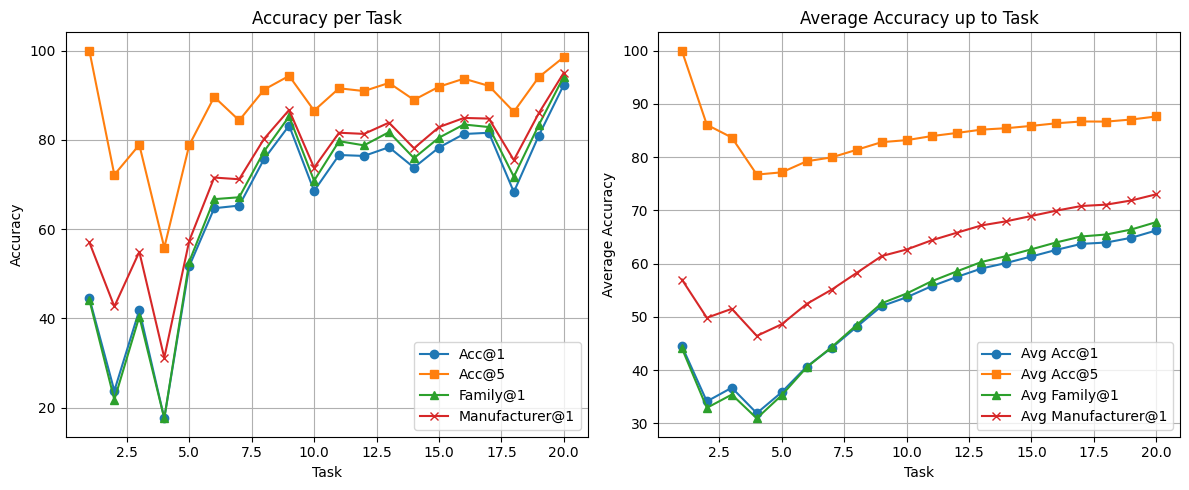

In [18]:
import matplotlib.pyplot as plt

x = list(range(1, len(acc1_list) + 1))  # Automatically generates [1, 2, ..., 20]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(x, acc1_list, label='Acc@1', marker='o')
plt.plot(x, acc5_list, label='Acc@5', marker='s')
plt.plot(x, fam_acc_list, label='Family@1', marker='^')
plt.plot(x, manu_acc_list, label='Manufacturer@1', marker='x')
plt.xlabel("Task")
plt.ylabel("Accuracy")
plt.title("Accuracy per Task")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(x, [sum(acc1_list[:i+1])/(i+1) for i in range(len(acc1_list))], label='Avg Acc@1', marker='o')
plt.plot(x, [sum(acc5_list[:i+1])/(i+1) for i in range(len(acc5_list))], label='Avg Acc@5', marker='s')
plt.plot(x, [sum(fam_acc_list[:i+1])/(i+1) for i in range(len(fam_acc_list))], label='Avg Family@1', marker='^')
plt.plot(x, [sum(manu_acc_list[:i+1])/(i+1) for i in range(len(manu_acc_list))], label='Avg Manufacturer@1', marker='x')
plt.xlabel("Task")
plt.ylabel("Average Accuracy")
plt.title("Average Accuracy up to Task")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


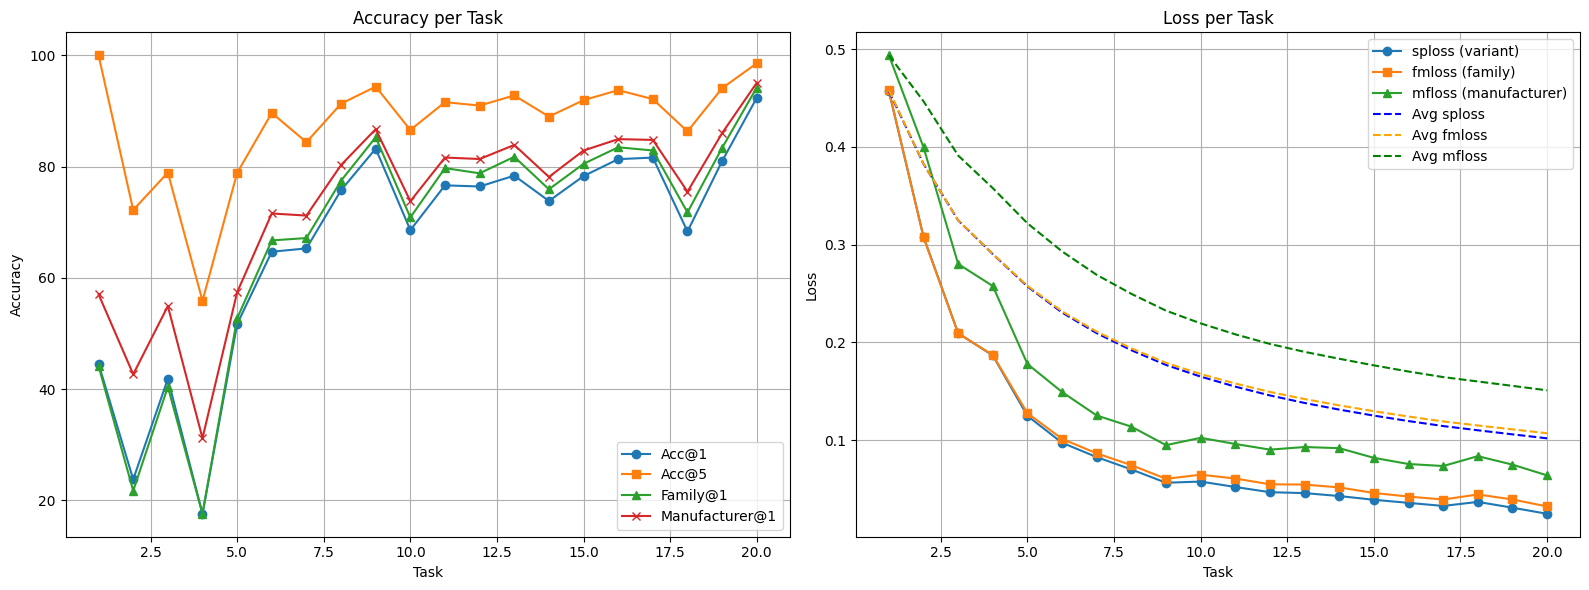

In [19]:
import matplotlib.pyplot as plt


x = list(range(1, len(acc1_list) + 1))

# ── Accuracy Plot ─────────────────────────────────────────────
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.plot(x, acc1_list, label='Acc@1', marker='o')
plt.plot(x, acc5_list, label='Acc@5', marker='s')
plt.plot(x, fam_acc_list, label='Family@1', marker='^')
plt.plot(x, manu_acc_list, label='Manufacturer@1', marker='x')
plt.xlabel("Task")
plt.ylabel("Accuracy")
plt.title("Accuracy per Task")
plt.legend()
plt.grid(True)

# ── Loss Plot ─────────────────────────────────────────────
plt.subplot(1, 2, 2)
plt.plot(x, sploss_list, label='sploss (variant)', marker='o')
plt.plot(x, fmloss_list, label='fmloss (family)', marker='s')
plt.plot(x, mfloss_list, label='mfloss (manufacturer)', marker='^')

# Optional: Add average lines
plt.plot(x, [sum(sploss_list[:i+1])/(i+1) for i in range(len(sploss_list))], 
         label='Avg sploss', linestyle='--', color='blue')
plt.plot(x, [sum(fmloss_list[:i+1])/(i+1) for i in range(len(fmloss_list))], 
         label='Avg fmloss', linestyle='--', color='orange')
plt.plot(x, [sum(mfloss_list[:i+1])/(i+1) for i in range(len(mfloss_list))], 
         label='Avg mfloss', linestyle='--', color='green')

plt.xlabel("Task")
plt.ylabel("Loss")
plt.title("Loss per Task")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import os
import json
import random

# ── Paths ─────────────────────────────────────────────────────────────
base_path = "/kaggle/input/fgvc-aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data"
test_split_path = os.path.join(base_path, "images_variant_test.txt")
hierarchy_csv_path = "/kaggle/working/hierarchy_full.csv"
train_task_split_path = "/kaggle/working/task_split.json"
output_test_split_path = "/kaggle/working/task_split_test.json"

# ── Step 1: Load test image-to-variant mapping ────────────────────────
records = []
with open(test_split_path, "r") as f:
    for line in f:
        parts = line.strip().split(" ", 1)
        if len(parts) == 2:
            image, variant = parts
            records.append((image, variant))
test_df = pd.DataFrame(records, columns=["image", "variant"])

# ── Step 2: Load full variant → family/maker hierarchy ────────────────
hierarchy_df = pd.read_csv(hierarchy_csv_path)

# ── Step 3: Merge test image data with family & maker ─────────────────
test_df = test_df.merge(hierarchy_df, on="variant", how="left")

# ── Step 4: Report missing hierarchy info ─────────────────────────────
if test_df[["family", "maker"]].isnull().any().any():
    missing = test_df[test_df["family"].isnull() | test_df["maker"].isnull()]
    print(" Warning: Missing hierarchy info for variants:", missing["variant"].unique().tolist())

# ── Step 5: Load training task split ──────────────────────────────────
with open(train_task_split_path, "r") as f:
    train_task_split = json.load(f)

# ── Step 6: Build variant → task reverse map ──────────────────────────
variant_to_task = {
    entry["variant"]: task
    for task, entries in train_task_split.items()
    for entry in entries
}

# ── Step 7: Assign test samples to tasks ──────────────────────────────
test_task_split = {f"task_{i+1}": [] for i in range(20)}

unmapped_variants = set()

for _, row in test_df.iterrows():
    variant = row["variant"]
    family = row["family"]
    maker = row["maker"]
    image = row["image"]

    task_name = variant_to_task.get(variant)
    if task_name:
        test_task_split[task_name].append({
            "image": image,
            "variant": variant,
            "family": family,
            "manufacturer": maker
        })
    else:
        unmapped_variants.add(variant)

# ── Step 8: Report unmapped variants (if any) ─────────────────────────
if unmapped_variants:
    print(f" {len(unmapped_variants)} test variants not assigned to any task:")
    print(sorted(unmapped_variants))

# ── Step 9: Optional sorting per task for reproducibility ─────────────
for task in test_task_split:
    test_task_split[task].sort(key=lambda x: x["image"])  # replace with random.shuffle(...) if randomness needed

# ── Step 10: Save to JSON ─────────────────────────────────────────────
with open(output_test_split_path, "w") as f:
    json.dump(test_task_split, f, indent=4)

# ── Step 11: Summary Output ───────────────────────────────────────────
print(" Test task split saved to:", output_test_split_path)
for task_name, entries in test_task_split.items():
    print(f"{task_name}: {len(entries)} samples")


In [ ]:
import os
import json
import torch
from PIL import Image
import numpy as np
from skimage.segmentation import slic
from skimage.util import img_as_float
import pandas as pd
from tqdm import tqdm

#  Paths
base_path = "/kaggle/input/fgvc-aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data"
img_dir = os.path.join(base_path, "images")
seg_dir = "/kaggle/working/segment_maps_test"
mapping_file = "/kaggle/working/mapping_test.txt"
task_split_path = "/kaggle/working/task_split_test.json"
variant_label_file = os.path.join(base_path, "images_variant_test.txt")

#  Create output directory
os.makedirs(seg_dir, exist_ok=True)
mapping = []

#  Step 1: Load test task split
with open(task_split_path, "r") as f:
    task_split = json.load(f)

#  Step 2: Collect all variants from the test tasks
all_variants = {entry["variant"] for task in task_split.values() for entry in task}

#  Step 3: Load image → variant mapping from file
def load_variant_mapping(file_path):
    records = []
    with open(file_path, "r") as f:
        for line in f:
            parts = line.strip().split(" ", 1)
            if len(parts) == 2:
                image, variant = parts
                records.append((image, variant))
    return pd.DataFrame(records, columns=["image", "variant"])

variant_df = load_variant_mapping(variant_label_file)
variant_df = variant_df[variant_df["variant"].isin(all_variants)].drop_duplicates().sort_values("image")

#  Step 4: Generate SLIC superpixels and save segment maps
print(f" Generating test-time superpixel maps for {len(variant_df)} images...")

skipped = 0

for _, row in tqdm(variant_df.iterrows(), total=len(variant_df)):
    image_id = row["image"]
    img_path = os.path.join(img_dir, f"{image_id}.jpg")

    if not os.path.exists(img_path):
        print(f" Image not found: {img_path}")
        skipped += 1
        continue

    try:
        image = Image.open(img_path).convert("RGB")
        resized = image.resize((224, 224))
        image_np = img_as_float(np.array(resized))

        segments = slic(image_np, n_segments=196, compactness=10, start_label=0)
        num_segments = len(np.unique(segments))

        normalized_segments = segments.astype(np.int64)
        seg_tensor = torch.from_numpy(normalized_segments).long()

        seg_save_path = os.path.join(seg_dir, image_id + ".pt")
        torch.save(seg_tensor, seg_save_path)

        mapping.append(f"{image_id} segment_maps_test/{image_id}.pt")

        # Optional log
        # print(f"{image_id}: {num_segments} superpixels")

    except Exception as e:
        print(f" Error processing {image_id}: {e}")
        skipped += 1

#  Step 5: Save mapping file
with open(mapping_file, "w") as f:
    f.writelines([line + "\n" for line in mapping])

#  Final summary
print("\n Test superpixel map generation complete.")
print(f" mapping_test.txt saved at {mapping_file}")
print(f" Segment maps created: {len(mapping)}")
print(f" Skipped or failed images: {skipped}")


In [24]:
%%writefile cast_models/engine_hier_eval.py

import torch
import csv
import torch.nn.functional as F

def evaluate_detail(data_loader, model, device, filename, nb_classes, trees, dataset='AIR', args=None):
    """
    Evaluation with variant, family, maker heads + hierarchical consistency (FPA / TICE).
    Handles BCE vs. CE targets based on args.bce_loss.
    """

    def get_hard(t):
        return t.argmax(dim=1) if t.ndim == 2 else t

    model.eval()
    total_samples = 0
    correct_variant = 0
    correct_family = 0
    correct_maker = 0
    fpa_cnt = 0
    tice_cnt = 0
    all_preds = []

    with open(filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([
            "image_name", "gt_variant", "gt_family", "gt_maker",
            "pred_variant", "pred_family", "pred_maker", "full_path_correct"
        ])

        for batch in data_loader:
            images = batch["image"].to(device, non_blocking=True)
            segments = batch["segments"].to(device, non_blocking=True)
            targets = batch["variant"].to(device, non_blocking=True)
            family_targets = batch["family"].to(device, non_blocking=True)
            maker_targets = batch.get("maker")
            if maker_targets is not None:
                maker_targets = maker_targets.to(device, non_blocking=True)
            else:
                maker_targets = torch.zeros_like(targets)

            image_names = batch["image_name"]

            with torch.no_grad():
                out = model(images, segments)
                if isinstance(out, tuple):
                    if len(out) == 3:
                        logits_variant, logits_family, logits_maker = out
                    else:
                        logits_variant, logits_family = out
                        logits_maker = torch.zeros_like(logits_variant[:, :1])  # dummy
                else:
                    raise ValueError("Expected model to return (variant, family, [maker])")

                pv = torch.argmax(logits_variant, dim=1)
                pf = torch.argmax(logits_family, dim=1)
                pm = torch.argmax(logits_maker, dim=1) if logits_maker.numel() > 1 else torch.zeros_like(pv)

            bs = images.size(0)
            total_samples += bs
            correct_variant += (pv == get_hard(targets)).sum().item()
            correct_family += (pf == get_hard(family_targets)).sum().item()
            correct_maker += (pm == get_hard(maker_targets)).sum().item()

            for i in range(bs):
                gv = get_hard(targets)[i].item()
                gf = get_hard(family_targets)[i].item()
                gm = get_hard(maker_targets)[i].item()
                predv = pv[i].item()
                predf = pf[i].item()
                predm = pm[i].item()

                full_correct = (gv == predv and gf == predf and gm == predm)
                if full_correct:
                    fpa_cnt += 1
                if (predv, predf, predm) in trees:
                    tice_cnt += 1

                writer.writerow([
                    image_names[i], gv, gf, gm, predv, predf, predm, int(full_correct)
                ])
                all_preds.append({
                    "variant": predv,
                    "family": predf,
                    "maker": predm,
                    "gt_variant": gv,
                    "gt_family": gf,
                    "gt_maker": gm
                })

    acc_variant = correct_variant / total_samples
    acc_family = correct_family / total_samples
    acc_maker = correct_maker / total_samples
    fpa = fpa_cnt / total_samples
    tice = 1 - (tice_cnt / total_samples)

    print("================ Evaluation Summary ================")
    print(f"Variant Top-1 Accuracy: {acc_variant * 100:.2f}%")
    print(f"Family  Top-1 Accuracy: {acc_family * 100:.2f}%")
    print(f"Maker   Top-1 Accuracy: {acc_maker * 100:.2f}%")
    print(f"FPA (Full Path Accuracy): {fpa * 100:.2f}%")
    print(f"TICE (Tree-Induced Error): {tice * 100:.2f}%")

    return {
        "variant_acc1": acc_variant,
        "family_acc1": acc_family,
        "maker_acc1": acc_maker,
        "fpa": fpa,
        "tice": tice,
        "total_samples": total_samples,
        "predictions": all_preds
    }


Writing cast_models/engine_hier_eval.py


In [ ]:
    import os
    import json
    import torch
    import pandas as pd
    import matplotlib.pyplot as plt
    from torch.utils.data import DataLoader, Dataset
    import torchvision.transforms as transforms
    from PIL import Image
    
    from cast_models.cast import cast_small
    from cast_models.engine_hier_eval import evaluate_detail
    
    #  Custom Test Dataset
    class AircraftHCASTTestDataset(Dataset):
        def __init__(self, image_dir, label_file, split_file, mapping_file, transform=None):
            self.image_dir = image_dir
            self.transform = transform
    
            hierarchy = pd.read_csv(label_file)
            self.variant_to_id = {v: i for i, v in enumerate(sorted(hierarchy["variant"].unique()))}
            self.family_to_id = {f: i for i, f in enumerate(sorted(hierarchy["family"].unique()))}
            self.maker_to_id = {m: i for i, m in enumerate(sorted(hierarchy["maker"].unique()))}
    
            with open(split_file, "r") as f:
                self.data = json.load(f)
    
            seg_map = {}
            with open(mapping_file, "r") as f:
                for line in f:
                    img, path = line.strip().split()
                    seg_map[img] = path
    
            self.samples = []
            for task_name, entries in self.data.items():
                for entry in entries:
                    img = entry["image"]
                    var = self.variant_to_id[entry["variant"]]
                    fam = self.family_to_id[entry["family"]]
                    mak = self.maker_to_id[entry["manufacturer"]]
                    seg_path = seg_map.get(img)
                    if seg_path:
                        self.samples.append({
                            "image": img,
                            "variant": var,
                            "family": fam,
                            "maker": mak,
                            "segment_path": seg_path
                        })
    
        def __len__(self):
            return len(self.samples)
    
        def __getitem__(self, idx):
            sample = self.samples[idx]
            image_path = os.path.join(self.image_dir, sample["image"] + ".jpg")
            segment_path = os.path.join("/kaggle/working", sample["segment_path"])
    
            image = Image.open(image_path).convert("RGB")
            image = self.transform(image)
            segment = torch.load(segment_path)
    
            return {
                "image": image,
                "segments": segment,
                "variant": torch.tensor(sample["variant"], dtype=torch.long),
                "family": torch.tensor(sample["family"], dtype=torch.long),
                "maker": torch.tensor(sample["maker"], dtype=torch.long),
                "image_name": sample["image"]
            }
    
    #  Remapping Wrapper
    class RemapTestDataset(torch.utils.data.Dataset):
        def __init__(self, base_dataset, vmap, fmap, mmap):
            self.base_dataset = base_dataset
            self.vmap = vmap
            self.fmap = fmap
            self.mmap = mmap
    
        def __len__(self):
            return len(self.base_dataset)
    
        def __getitem__(self, idx):
            item = self.base_dataset[idx]
            item["variant"] = torch.tensor(self.vmap[item["variant"].item()])
            item["family"] = torch.tensor(self.fmap[item["family"].item()])
            item["maker"] = torch.tensor(self.mmap[item["maker"].item()])
            return item
    
    #  Setup
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    
    #  Load mappings
    hierarchy_df = pd.read_csv("hierarchy_full.csv")
    variant2id = {v: i for i, v in enumerate(sorted(hierarchy_df["variant"].unique()))}
    family2id = {f: i for i, f in enumerate(sorted(hierarchy_df["family"].unique()))}
    maker2id = {m: i for i, m in enumerate(sorted(hierarchy_df["maker"].unique()))}
    
    with open("task_split_test.json", "r") as f:
        test_task_split = json.load(f)
    
    #  Collect label IDs used in test
    variant_ids = sorted({variant2id[entry["variant"]] for entries in test_task_split.values() for entry in entries})
    family_ids = sorted({family2id[entry["family"]] for entries in test_task_split.values() for entry in entries})
    maker_ids = sorted({maker2id[entry["manufacturer"]] for entries in test_task_split.values() for entry in entries})
    
    variant_id_map = {orig: i for i, orig in enumerate(variant_ids)}
    family_id_map = {orig: i for i, orig in enumerate(family_ids)}
    maker_id_map = {orig: i for i, orig in enumerate(maker_ids)}
    
    #  Full test dataset
    full_dataset = AircraftHCASTTestDataset(
        image_dir="/kaggle/input/fgvc-aircraft/fgvc-aircraft-2013b/fgvc-aircraft-2013b/data/images",
        label_file="hierarchy_full.csv",
        split_file="task_split_test.json",
        mapping_file="mapping_test.txt",
        transform=transform
    )
    remapped_dataset = RemapTestDataset(full_dataset, variant_id_map, family_id_map, maker_id_map)
    
    #  Tree set for hierarchical consistency
    trees = set(
        (variant_id_map[variant2id[row["variant"]]],
         family_id_map[family2id[row["family"]]],
         maker_id_map.get(maker2id.get(row["maker"], -1), -1))
        for _, row in hierarchy_df.iterrows()
        if variant2id[row["variant"]] in variant_id_map
    )
    
    #  Load model and expand heads
    model = cast_small(nb_classes=[len(variant_id_map), len(family_id_map), len(maker_id_map)], init_num_classes=0).to(device)
    model.head.expand(len(variant_id_map))
    model.family_head.expand(len(family_id_map))
    model.manufacturer_head.expand(len(maker_id_map))
    model.load_state_dict(torch.load("hcast_task20.pth", map_location=device), strict=False)
    model.eval()
    
    print(f" Loaded model with heads V: {len(variant_id_map)}, F: {len(family_id_map)}, M: {len(maker_id_map)}")
    
    #  Evaluate task-wise
    results = []
    
    for task_name, entries in test_task_split.items():
        print(f"\n Evaluating {task_name}...")
        task_image_names = set(entry["image"] for entry in entries)
    
        filtered_indices = [i for i in range(len(full_dataset)) if full_dataset[i]["image_name"] in task_image_names]
        if not filtered_indices:
            print(f" No matching samples for {task_name}, skipping.")
            continue
    
        task_dataset = torch.utils.data.Subset(remapped_dataset, filtered_indices)
        loader = DataLoader(task_dataset, batch_size=32, shuffle=False, num_workers=4)
    
        metrics = evaluate_detail(
            data_loader=loader,
            model=model,
            device=device,
            filename=f"{task_name}_preds.csv",
            nb_classes=[len(variant_id_map), len(family_id_map), len(maker_id_map)],
            trees=trees,
            dataset='AIR'
        )
    
        print(f"✔️ {task_name}: V@1 = {metrics['variant_acc1']*100:.2f}%, F@1 = {metrics['family_acc1']*100:.2f}%, "
              f"M@1 = {metrics['maker_acc1']*100:.2f}%, FPA = {metrics['fpa']*100:.2f}%, TICE = {metrics['tice']*100:.2f}%")
    
        results.append({**metrics, "task": task_name, "num_images": len(task_dataset)})
    
    #  Save CSV and plot
    summary_df = pd.DataFrame(results)
    summary_df.to_csv("test_taskwise_metrics.csv", index=False)
    
    x = range(1, len(summary_df) + 1)
    plt.figure(figsize=(24, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(x, summary_df["variant_acc1"], label='Variant Acc@1')
    plt.plot(x, summary_df["family_acc1"], label='Family Acc@1')
    plt.plot(x, summary_df["maker_acc1"], label='Maker Acc@1')
    plt.xlabel("Task")
    plt.ylabel("Accuracy")
    plt.title("Test Accuracy per Task")
    plt.xticks(x, summary_df["task"], rotation=45)
    plt.ylim(0, 1)
    plt.legend()
    
    # plt.subplot(1, 2, 2)
    # plt.plot(x, summary_df["fpa"], label='FPA')
    # plt.plot(x, summary_df["tice"], label='TICE')
    # plt.xlabel("Task")
    # plt.ylabel("Value")
    # plt.title("FPA / TICE per Task")
    # plt.xticks(x, summary_df["task"], rotation=45)
    # plt.ylim(0, 1)
    # plt.legend()
    
    plt.tight_layout()
    plt.savefig("test_taskwise_plot.png")
    print(" Saved test_taskwise_plot.png")


In [29]:
summary_df

,variant_acc1,family_acc1,maker_acc1,fpa,tice,total_samples,predictions,task,num_images
0,0.712575,0.754491,0.772455,0.688623,0.095808,167,"[{'variant': 76, 'family': 58, 'maker': 21, 'g...",task_1,167
1,0.722892,0.753012,0.813253,0.704819,0.090361,166,"[{'variant': 1, 'family': 14, 'maker': 4, 'gt_...",task_2,166
2,0.536145,0.578313,0.638554,0.512048,0.180723,166,"[{'variant': 56, 'family': 32, 'maker': 21, 'g...",task_3,166
3,0.765060,0.867470,0.873494,0.759036,0.054217,166,"[{'variant': 60, 'family': 37, 'maker': 29, 'g...",task_4,166
4,0.508982,0.730539,0.814371,0.508982,0.113772,167,"[{'variant': 98, 'family': 1, 'maker': 1, 'gt_...",task_5,167
5,0.724551,0.772455,0.814371,0.712575,0.083832,167,"[{'variant': 83, 'family': 54, 'maker': 18, 'g...",task_6,167
6,0.710059,0.792899,0.881657,0.692308,0.059172,169,"[{'variant': 8, 'family': 15, 'maker': 4, 'gt_...",task_7,169
7,0.461078,0.604790,0.640719,0.431138,0.179641,167,"[{'variant': 69, 'family': 41, 'maker': 13, 'g...",task_8,167
8,0.807229,0.825301,0.837349,0.789157,0.090361,166,"[{'variant': 40, 'family': 11, 'maker': 3, 'gt...",task_9,166
9,0.636364,0.818182,0.866667,0.612121,0.109091,165,"[{'variant': 61, 'family': 37, 'maker': 29, 'g...",task_10,165


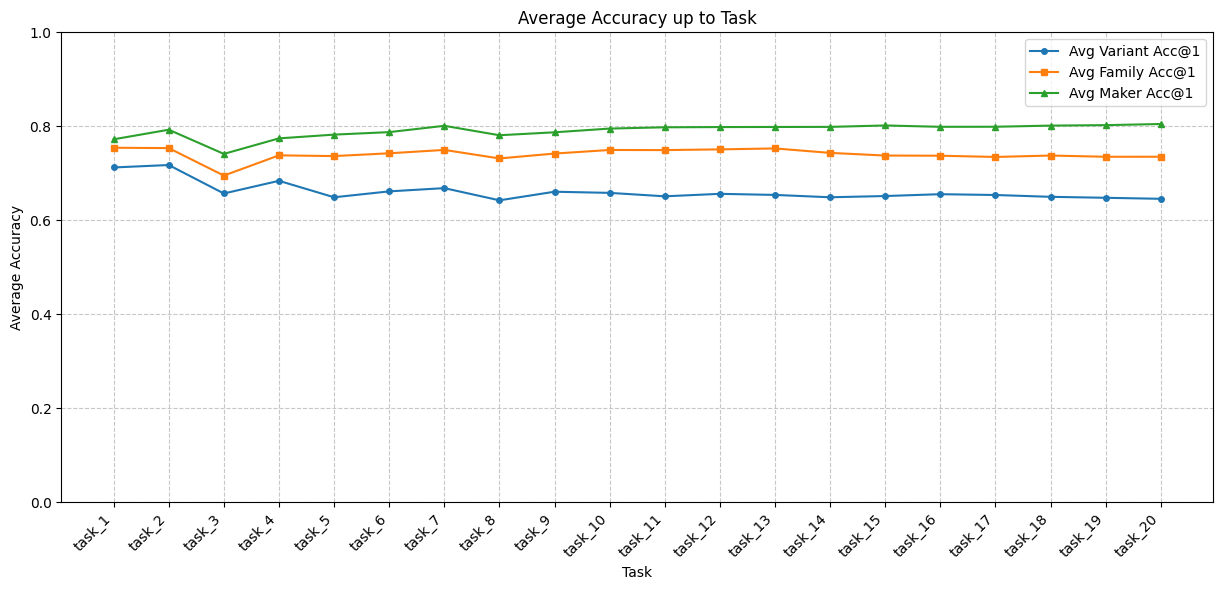

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


x = range(1, len(summary_df) + 1)

plt.figure(figsize=(24, 6))


# --- New Plot: Average Accuracy up to Task ---
plt.subplot(1, 2, 2)

# Calculate cumulative averages
avg_variant_acc1 = [summary_df["variant_acc1"].iloc[:i+1].mean() for i in range(len(summary_df))]
avg_family_acc1 = [summary_df["family_acc1"].iloc[:i+1].mean() for i in range(len(summary_df))]
avg_maker_acc1 = [summary_df["maker_acc1"].iloc[:i+1].mean() for i in range(len(summary_df))]

plt.plot(x, avg_variant_acc1, label='Avg Variant Acc@1', marker='o', markersize=4)
plt.plot(x, avg_family_acc1, label='Avg Family Acc@1', marker='s', markersize=4)
plt.plot(x, avg_maker_acc1, label='Avg Maker Acc@1', marker='^', markersize=4)

plt.xlabel("Task")
plt.ylabel("Average Accuracy")
plt.title("Average Accuracy up to Task")
plt.xticks(x, summary_df["task"], rotation=45, ha='right') # Use task names for x-axis
plt.ylim(0, 1) # Set y-axis limit from 0 to 1 for accuracy
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)


plt.tight_layout() # Adjust layout to prevent overlapping
plt.show()